# Multi-group Agreement (Employment)
In this notebook, we empirically investigate the "agreement" between group-wise optimal classifiers for the Employment
dataset. One hypothesis for why we just see uniform performance improvement for all groups (and their intersections) in
the previous notebook (`experiments_adult_trees.ipynb`) might be that, on intersections, the optimal predictors already
agree, or are close to functionally equivalent. We test this hypothesis out on several different model classes:

1. Decision Trees of fixed depth (`DecisionTreeClassifier`).
2. Logistic Regression (`LogisticRegression`).
3. Gradient-boosted Trees (`GradientBoostingClassifier`).
4. XGBoost (`XGBoostClassifier`).

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer

from folktables import ACSDataSource, ACSEmployment

# ACS Employment Dataset (2016, California)
The ACS Employment is a benchmark derived from the 2018 American Community Survey. The task is to predict whether an 
individual is employed, after filtering the survey sample to only include individuals between the ages of 16 and 90.
The full dataset has $n = 3,236,107$ examples, but we use a subsample of the dataset from California in 2016 to get a dataset
of $n = 376,035$ examples total.

## Preprocess and Clean ACS Employment
The ACS Employment dataset (California, 2016) is a binary classification task with $d=16$ features.

We run the following experiments with the following (overlapping) group structure, $\mathcal{G}$. We let $|\mathcal{G}| = 12.$
- **Race.** Note that we dropped race values $4$ and $5$ because they are too small in the dataset (*Alaska Native alone*
and *American Indian and Alaska Native tribes specified*). The possible values for race are:
  - White alone
  - Black or African-American alone
  - American Indian alone
  - Asian alone
  - Native Hawaiian and Other Pacific Islander alone
  - Some Other Race alone
  - Two or More Races
- **Sex.** The possible values for sex are:
  - Male
  - Female
- **Age.** Split between $\mathrm{Age} > 65$ and $\mathrm{Age} \leq 65$. The possible values for age are:
  - 0 - 99 (integers)

In [3]:
data_source = ACSDataSource(survey_year='2016', horizon='1-Year', survey='person')
acs_data = data_source.get_data(states=["CA"], download=True)
features, label, group = ACSEmployment.df_to_numpy(acs_data)
sex = features[:, -2]
old = (features[:,0] > 65)
features.shape

(376035, 16)

In [4]:
group_names = []
group_memberships = []
group_memberships.append([True] * label.shape[0])
group_names.append('ALL')
for g in np.unique(group):
    if g == 4 or g == 5: # group is too small
        continue
    group_memberships.append(group == g)
    group_names.append('R{0}'.format(g))
group_memberships.append(sex == 1)
group_names.append('S1')
group_memberships.append(sex == 2)
group_names.append('S2')
group_memberships.append(old == False)
group_names.append('A1')
group_memberships.append(old == True)
group_names.append('A2')
num_groups = len(group_memberships)
print('num_groups = {0}'.format(num_groups))

num_groups = 12


In [5]:
to_one_hot = set(['MAR', 'RELP', 'ESP', 'CIT', 'MIG', 'MIL', 'ANC', 'DREM', 'RAC1P'])
to_leave_alone = set(ACSEmployment.features) - to_one_hot
one_hot_inds = [i for i, x in enumerate(ACSEmployment.features) if x in to_one_hot]
leave_alone_inds = [i for i, x in enumerate(ACSEmployment.features) if x in to_leave_alone]

steps = [('onehot', OneHotEncoder(handle_unknown='ignore'), one_hot_inds), ('num', MinMaxScaler(), leave_alone_inds)]
col_transf = ColumnTransformer(steps)
features_t = col_transf.fit_transform(features).toarray()
print("Column-transformed X has shape: {}".format(features_t.shape))

Column-transformed X has shape: (376035, 69)


In [6]:
# Train-test split
splits = train_test_split(*tuple([features, label] + group_memberships), test_size=0.2, random_state=0)
X_train = splits[0]
X_test = splits[1]
y_train = splits[2]
y_test = splits[3]

# group_train
group_train = splits[4::2]
group_test = splits[5::2]

In [7]:
# group_train and group_test have the indices in X_train, X_test (respectively)
# for each group, as a binary mask.
num_group_train = {}
num_group_test = {}

print('Group\ttrain\ttest')
for g in range(num_groups):
    num_group_train[g] = np.sum(group_train[g])
    num_group_test[g] = np.sum(group_test[g])
    print('{0} ({3})\t{1}\t{2}'.format(g, num_group_train[g], num_group_test[g], group_names[g]))

Group	train	test
0 (ALL)	300828	75207
1 (R1)	184961	46271
2 (R2)	15047	3784
3 (R3)	2080	517
4 (R6)	45385	11425
5 (R7)	1057	280
6 (R8)	37135	9181
7 (R9)	14416	3562
8 (S1)	148622	36981
9 (S2)	152206	38226
10 (A1)	254184	63388
11 (A2)	46644	11819


In [8]:
for i in range(num_groups):
    print('P(Y=1 | group {0}) = {1}'.format(i, np.mean(y_test[group_test[i]])))

P(Y=1 | group 0) = 0.44420067280971187
P(Y=1 | group 1) = 0.44883404292105206
P(Y=1 | group 2) = 0.38847780126849896
P(Y=1 | group 3) = 0.3307543520309478
P(Y=1 | group 4) = 0.47728665207877463
P(Y=1 | group 5) = 0.4642857142857143
P(Y=1 | group 6) = 0.44298006753077007
P(Y=1 | group 7) = 0.3571027512633352
P(Y=1 | group 8) = 0.4840593818447311
P(Y=1 | group 9) = 0.4056401402186993
P(Y=1 | group 10) = 0.49899034517574303
P(Y=1 | group 11) = 0.15035112953718588


## Utilities for Training/Evaluation

In [9]:
# Utilities for fitting and evaluating models
def std_err(test_err, n_g):
    return np.sqrt(2. * test_err * (1.0 - test_err) / n_g)

def prepend(models, X_train, group_train, X_test, group_test, y_train, y_test,
            transformer, num_groups, epsilon=0, verbose=False):
    f = [0]
    #epsilon = 0.01
    epsilon = 0

    H_train = {}
    H_test = {}
    H_train_err = {}
    for g in range(num_groups):
        H_train[g] = models[g].predict(transformer.transform(X_train))
        H_test[g] = models[g].predict(transformer.transform(X_test))
        H_train_err[g] = np.mean(H_train[g][group_train[g]] != y_train[group_train[g]])
    F_train = H_train[0].copy()
    F_test = H_test[0].copy()
    F_train_err = {}
    for g in range(num_groups):
        F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
    while True:
        #scores = [H_train_err[g] + np.sqrt(2.0 * H_train_err[g] * (1.0 - H_train_err[g])/num_group_train[g]) - F_train_err[g] for g in range(num_groups)]
        scores = [H_train_err[g] + epsilon - F_train_err[g] for g in range(num_groups)]
        g = np.argmin(scores)
        if scores[g] < 0.:
            f.insert(0,g) # prepend g to the list f
            F_train[group_train[g]] = H_train[g][group_train[g]]
            F_test[group_test[g]] = H_test[g][group_test[g]]
            for g in range(num_groups):
                F_train_err[g] = np.mean(F_train[group_train[g]] != y_train[group_train[g]])
        else:
            break

    F_test_err = {}
    for g in range(num_groups):
        F_test_err[g] = np.mean(F_test[group_test[g]] != y_test[group_test[g]])
        if verbose:
            print('PREPEND group {0} ({4}): {1} (+/-{2}; n={3})'.format(g, F_test_err[g], std_err(F_test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    return f, F_test_err

def train_and_eval(X_train, group_train, 
                   X_test, group_test, 
                   y_train, y_test, 
                   transformer, num_groups, 
                   model, params={}, verbose=False):
    models = {}
    yhats = {}
    test_err = {}
    erm_test_err = {}

    # train and evaluate all models
    for g in range(num_groups):
        models[g] = model(**params)
        models[g].fit(transformer.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = models[g].predict(transformer.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        if verbose:
            print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))
    for g in range(num_groups):
        erm_test_err[g] = np.mean(y_test[group_test[g]] != yhats[0][group_test[g]])
    
    dec_list, F_test_err = prepend(models, X_train, group_train, X_test, group_test, y_train, y_test, col_transf, num_groups, verbose=verbose)
    return models, yhats, test_err, erm_test_err, dec_list, F_test_err

In [16]:
# Construct pairs of groups for "agreement" comparison
race_sex_train = {}
race_sex_test = {}
race_age_train = {}
race_age_test = {}
sex_age_train = {}
sex_age_test = {}

# Race-Sex Intersections
for r in range(1, 8):
    race_sex_train[r] = {}
    race_sex_test[r] = {}

    r_s1_train = np.logical_and(group_train[r], group_train[8]) # R and S1
    r_s2_train = np.logical_and(group_train[r], group_train[9]) # R and S2
    race_sex_train[r][8] = r_s1_train
    race_sex_train[r][9] = r_s2_train

    r_s1_test = np.logical_and(group_test[r], group_test[8])    # R and S1
    r_s2_test = np.logical_and(group_test[r], group_test[9])    # R and S2
    race_sex_test[r][8] = r_s1_test
    race_sex_test[r][9] = r_s2_test

# Race-Age Intersections
for r in range(1, 8):
    race_age_train[r] = {}
    race_age_test[r] = {}

    r_a1_train = np.logical_and(group_train[r], group_train[10]) # R and S1
    r_a2_train = np.logical_and(group_train[r], group_train[11]) # R and S2
    race_age_train[r][10] = r_a1_train
    race_age_train[r][11] = r_a2_train

    r_a1_test = np.logical_and(group_test[r], group_test[10])    # R and S1
    r_a2_test = np.logical_and(group_test[r], group_test[11])    # R and S2
    race_age_test[r][10] = r_a1_test
    race_age_test[r][11] = r_a2_test

# Sex-Age Intersections
sex_age_train[8] = {}
sex_age_train[9] = {}
sex_age_train[8][10] = group_train[8] & group_train[10]
sex_age_train[8][11] = group_train[8] & group_train[11]
sex_age_train[9][10] = group_train[9] & group_train[10]
sex_age_train[9][11] = group_train[9] & group_train[11]

sex_age_test[8] = {}
sex_age_test[9] = {}
sex_age_test[8][10] = group_test[8] & group_test[10]
sex_age_test[8][11] = group_test[8] & group_test[11]
sex_age_test[9][10] = group_test[9] & group_test[10]
sex_age_test[9][11] = group_test[9] & group_test[11]

In [17]:
# Race-Sex Group Intersections
race_sex_pairs = list()
for r in range(1, 8):
    race_sex_pairs.append((r, 8)) # (race, S1)
    race_sex_pairs.append((r, 9)) # (race, S2)

race_age_pairs = list()
for r in range(1, 8):
    race_age_pairs.append((r, 10)) # (race, A1)
    race_age_pairs.append((r, 11)) # (race, A2)

sex_age_pairs = list()
sex_age_pairs.append((8, 10))
sex_age_pairs.append((8, 11))
sex_age_pairs.append((9, 10))
sex_age_pairs.append((9, 11))

# Logistic Regression

In [20]:
from sklearn.linear_model import LogisticRegressionCV
import warnings
import os
import pickle
def warn(*args, **kwargs):
    pass
warnings.warn = warn

In [27]:
# Train LogisticRegression models, one per group
LOAD_DATA = True
SAVE_DATA_PATH = 'employment_agreement_data/'
model_path = os.path.join(SAVE_DATA_PATH, 'logreg_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'logreg_yhats.pkl')
prepend_path = os.path.join(SAVE_DATA_PATH, 'logreg_declist.pkl')

# Train LogisticRegression models, one per group

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        logreg_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
    with open(prepend_path, 'rb') as f:
        dec_list = pickle.load(f)
else:
    params = {'max_iter': 250}
    logreg_models, yhats, test_err, erm_test_err, dec_list, F_test_err = train_and_eval(X_train, group_train, X_test, group_test, 
                                                                                        y_train, y_test, col_transf, num_groups, 
                                                                                        LogisticRegressionCV, params=params, verbose=True)

    with open(model_path, 'wb') as handle:
        pickle.dump(logreg_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(prepend_path, 'wb') as handle:
        pickle.dump(dec_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

test_err = {}
for g in range(num_groups):
    test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.20919595250442113 (+/-0.002097475737468698; n=75207)
group 1 (R1): 0.20552830066348252 (+/-0.002656657612160973; n=46271)
group 2 (R2): 0.21088794926004228 (+/-0.009378527443975845; n=3784)
group 3 (R3): 0.25338491295938104 (+/-0.02705256712731249; n=517)
group 4 (R6): 0.23326039387308534 (+/-0.00559540265373844; n=11425)
group 5 (R7): 0.2357142857142857 (+/-0.03587210030336845; n=280)
group 6 (R8): 0.20705805467813965 (+/-0.005980489949053107; n=9181)
group 7 (R9): 0.1656372824256036 (+/-0.008808957881882231; n=3562)
group 8 (S1): 0.17441388821286608 (+/-0.0027905987394349916; n=36981)
group 9 (S2): 0.2378485847329043 (+/-0.0030796863356841882; n=38226)
group 10 (A1): 0.20437622262888874 (+/-0.002265064294255182; n=63388)
group 11 (A2): 0.15009730095608764 (+/-0.004646176214296712; n=11819)


In [28]:
# Get "agreement" for each pair of intersecting groups
# Race-Sex Pairs
lr_race_sex_agreements = []
for g1, g2 in race_sex_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    lr_race_sex_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

# Race-Age Pairs
print()
lr_race_age_agreements = []
for g1, g2 in race_age_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    lr_race_age_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

# Sex-Age Pairs
print()
lr_sex_age_agreements = []
for g1, g2 in sex_age_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    lr_sex_age_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

(R1, S1) agreement:	0.9200340393846318
(R1, S2) agreement:	0.9291023441966838
(R2, S1) agreement:	0.911364633611233
(R2, S2) agreement:	0.8984403047588655
(R3, S1) agreement:	0.8907282566782347
(R3, S2) agreement:	0.9073224566862127
(R6, S1) agreement:	0.9277327908306408
(R6, S2) agreement:	0.9179464677490127
(R7, S1) agreement:	0.8976690999508025
(R7, S2) agreement:	0.9161248288058292
(R8, S1) agreement:	0.8815136888853431
(R8, S2) agreement:	0.8510112090629861
(R9, S1) agreement:	0.9201404124616059
(R9, S2) agreement:	0.8900900182163894

(R1, A1) agreement:	0.8786283191724175
(R1, A2) agreement:	0.692196205140479
(R2, A1) agreement:	0.9327988086215379
(R2, A2) agreement:	0.6396213118459718
(R3, A1) agreement:	0.8796388634036725
(R3, A2) agreement:	0.6454718310795537
(R6, A1) agreement:	0.9199143696730357
(R6, A2) agreement:	0.6614144959910646
(R7, A1) agreement:	0.883255548020796
(R7, A2) agreement:	0.6354195753054902
(R8, A1) agreement:	0.9461087398779369
(R8, A2) agreement:	0.61338

In [32]:
# Get group-conditional agreements
lr_race_sex_cond_agreements = []
for i, (g1, g2) in enumerate(race_sex_pairs):
    intersection = race_sex_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("({}, {}) agreement on {},{}:\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    lr_race_sex_cond_agreements.append(agreement)

(R1, S1) agreement on R1,S1:	0.9611091733519358
(R1, S2) agreement on R1,S2:	0.9390186415256053
(R2, S1) agreement on R2,S1:	0.92590618336887
(R2, S2) agreement on R2,S2:	0.9229559748427673
(R3, S1) agreement on R3,S1:	0.8924302788844621
(R3, S2) agreement on R3,S2:	0.8947368421052632
(R6, S1) agreement on R6,S1:	0.9391955098222639
(R6, S2) agreement on R6,S2:	0.9495065789473685
(R7, S1) agreement on R7,S1:	0.9022556390977443
(R7, S2) agreement on R7,S2:	0.9115646258503401
(R8, S1) agreement on R8,S1:	0.9629549393414212
(R8, S2) agreement on R8,S2:	0.9145673603504929
(R9, S1) agreement on R9,S1:	0.9634782608695652
(R9, S2) agreement on R9,S2:	0.95971692977681


In [33]:
lr_race_age_cond_agreements = []
for i, (g1, g2) in enumerate(race_age_pairs):
    intersection = race_age_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("({}, {}) agreement on {},{}:\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    lr_race_age_cond_agreements.append(agreement)

(R1, A1) agreement on R1,A1:	0.9240678146541399
(R1, A2) agreement on R1,A2:	0.8900896757875374
(R2, A1) agreement on R2,A1:	0.9086357947434293
(R2, A2) agreement on R2,A2:	0.8418367346938775
(R3, A1) agreement on R3,A1:	0.8771551724137931
(R3, A2) agreement on R3,A2:	0.8113207547169812
(R6, A1) agreement on R6,A1:	0.9325140809011777
(R6, A2) agreement on R6,A2:	0.7951807228915663
(R7, A1) agreement on R7,A1:	0.9215686274509803
(R7, A2) agreement on R7,A2:	0.88
(R8, A1) agreement on R8,A1:	0.9640087952783243
(R8, A2) agreement on R8,A2:	0.8111111111111111
(R9, A1) agreement on R9,A1:	0.9741974197419742
(R9, A2) agreement on R9,A2:	0.7554585152838428


In [34]:
lr_sex_age_cond_agreements = []
for i, (g1, g2) in enumerate(sex_age_pairs):
    intersection = sex_age_test[g1][g2]
    agreement = np.sum(yhats[g1][intersection] == yhats[g2][intersection])/len(y_test[intersection])
    print("({}, {}) agreement on {},{}:\t{}".format(group_names[g1], group_names[g2], group_names[g1], group_names[g2], agreement))
    lr_sex_age_cond_agreements.append(agreement)

(S1, A1) agreement on S1,A1:	0.9498282436733794
(S1, A2) agreement on S1,A2:	0.7876190476190477
(S2, A1) agreement on S2,A1:	0.8941782228259153
(S2, A2) agreement on S2,A2:	0.9150555640127873


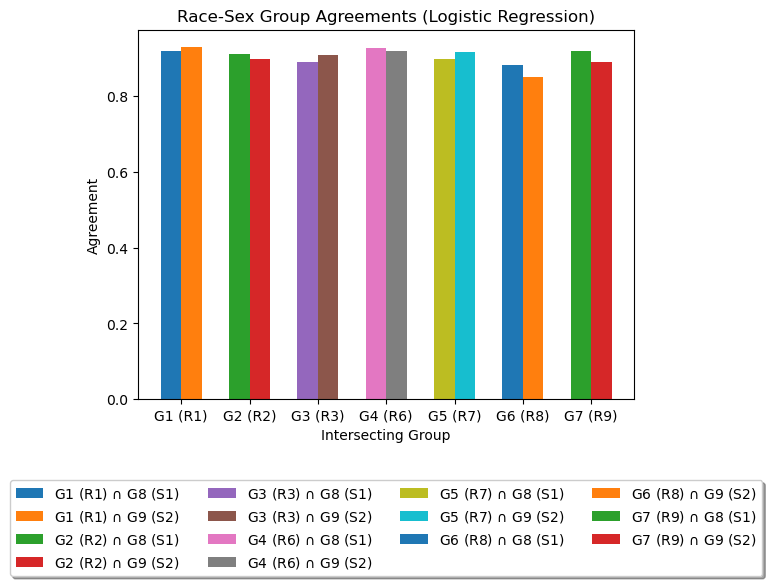

In [35]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, lr_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, lr_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Sex Group Agreements (Logistic Regression)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

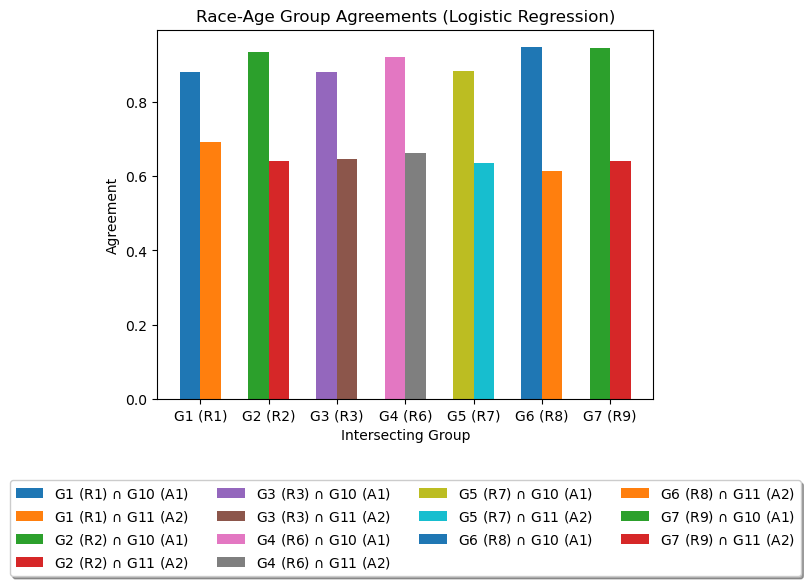

In [36]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, lr_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, lr_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Age Group Agreements (Logistic Regression)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

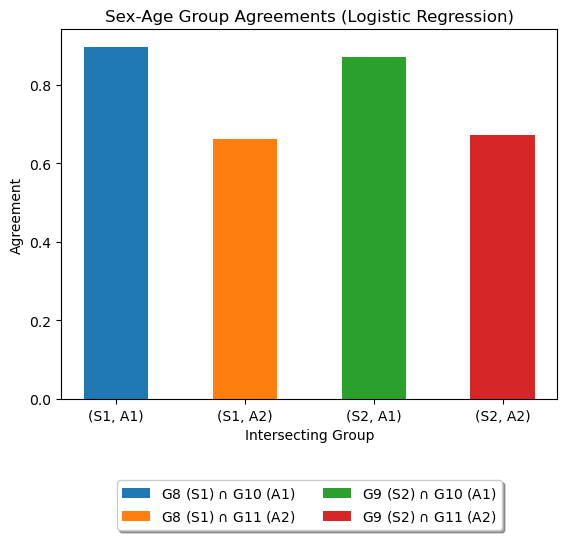

In [37]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 4
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.5

rect1 = ax.bar(0, lr_sex_age_agreements[0], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[0][0], group_names[sex_age_pairs[0][0]],
                                                            sex_age_pairs[0][1], group_names[sex_age_pairs[0][1]]))
rect2 = ax.bar(1, lr_sex_age_agreements[1], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[1][0], group_names[sex_age_pairs[1][0]],
                                                            sex_age_pairs[1][1], group_names[sex_age_pairs[1][1]]))
rect3 = ax.bar(2, lr_sex_age_agreements[2], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[2][0], group_names[sex_age_pairs[2][0]],
                                                            sex_age_pairs[2][1], group_names[sex_age_pairs[2][1]]))
rect4 = ax.bar(3, lr_sex_age_agreements[3], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[3][0], group_names[sex_age_pairs[3][0]],
                                                            sex_age_pairs[3][1], group_names[sex_age_pairs[3][1]]))


ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Sex-Age Group Agreements (Logistic Regression)')
ax.set_xticks(index, ('(S1, A1)', '(S1, A2)', '(S2, A1)', '(S2, A2)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)

plt.show()

# Decision Trees

In [71]:
from sklearn.tree import DecisionTreeClassifier

In [73]:
LOAD_DATA = True
SAVE_DATA_PATH = 'employment_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'dectree_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'dectree_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'dectree_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        dectree_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    dectree_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        dectree_models[g] = DecisionTreeClassifier(**best_params[g])
        dectree_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = dectree_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(dectree_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

for g in range(num_groups):
    test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.18564761258925366 (+/-0.0020051032299047192; n=75207)
group 1 (R1): 0.18620734369259365 (+/-0.002559268437454397; n=46271)
group 2 (R2): 0.18181818181818182 (+/-0.008867128483123024; n=3784)
group 3 (R3): 0.23017408123791103 (+/-0.026181480421782644; n=517)
group 4 (R6): 0.19045951859956237 (+/-0.005195262787057864; n=11425)
group 5 (R7): 0.21785714285714286 (+/-0.034887104470119584; n=280)
group 6 (R8): 0.1813527938133101 (+/-0.005686964554153246; n=9181)
group 7 (R9): 0.16058394160583941 (+/-0.00869976925043214; n=3562)
group 8 (S1): 0.15253778967577947 (+/-0.0026440798573251242; n=36981)
group 9 (S2): 0.21754826557840212 (+/-0.002984297818671847; n=38226)
group 10 (A1): 0.19164510632927367 (+/-0.0022108606812777203; n=63388)
group 11 (A2): 0.1501819104831204 (+/-0.004647254210559716; n=11819)


In [74]:
# Get "agreement" for each pair of intersecting groups
# Race-Sex Pairs
dt_race_sex_agreements = []
for g1, g2 in race_sex_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    dt_race_sex_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

# Race-Age Pairs
print()
dt_race_age_agreements = []
for g1, g2 in race_age_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    dt_race_age_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

# Sex-Age Pairs
print()
dt_sex_age_agreements = []
for g1, g2 in sex_age_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    dt_sex_age_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

(R1, S1) agreement:	0.9349528634302658
(R1, S2) agreement:	0.9328652917946467
(R2, S1) agreement:	0.9188240456340501
(R2, S2) agreement:	0.9393141595862088
(R3, S1) agreement:	0.8536306460834763
(R3, S2) agreement:	0.847793423484516
(R6, S1) agreement:	0.9268419163109817
(R6, S2) agreement:	0.8917255042748681
(R7, S1) agreement:	0.8717539590729586
(R7, S2) agreement:	0.8971106412966878
(R8, S1) agreement:	0.9304320076588616
(R8, S2) agreement:	0.9131596792851729
(R9, S1) agreement:	0.9400454744904064
(R9, S2) agreement:	0.9056204874546252

(R1, A1) agreement:	0.9466273086281862
(R1, A2) agreement:	0.5446966372811042
(R2, A1) agreement:	0.9263499408299759
(R2, A2) agreement:	0.5626337973858816
(R3, A1) agreement:	0.8503862672357626
(R3, A2) agreement:	0.6072705998111878
(R6, A1) agreement:	0.9172417461140585
(R6, A2) agreement:	0.559748427672956
(R7, A1) agreement:	0.8676851888786948
(R7, A2) agreement:	0.5889611339370006
(R8, A1) agreement:	0.9360431874692515
(R8, A2) agreement:	0.5538

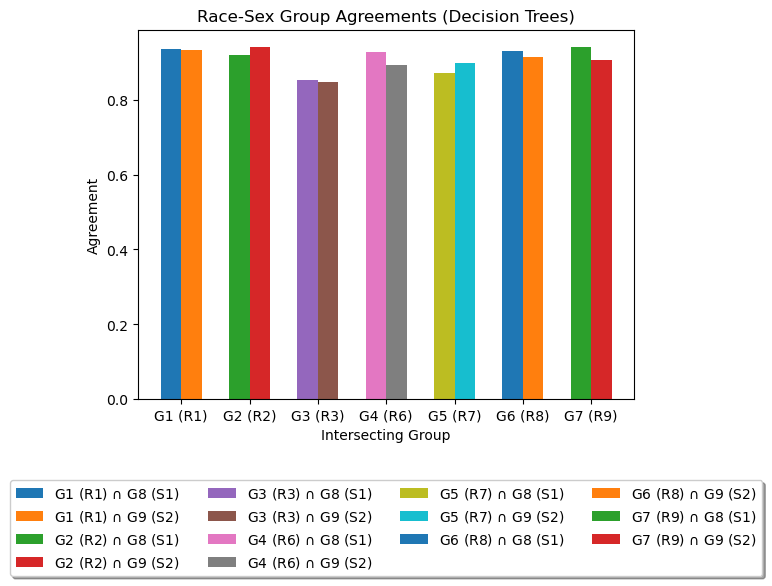

In [75]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, dt_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, dt_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Sex Group Agreements (Decision Trees)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

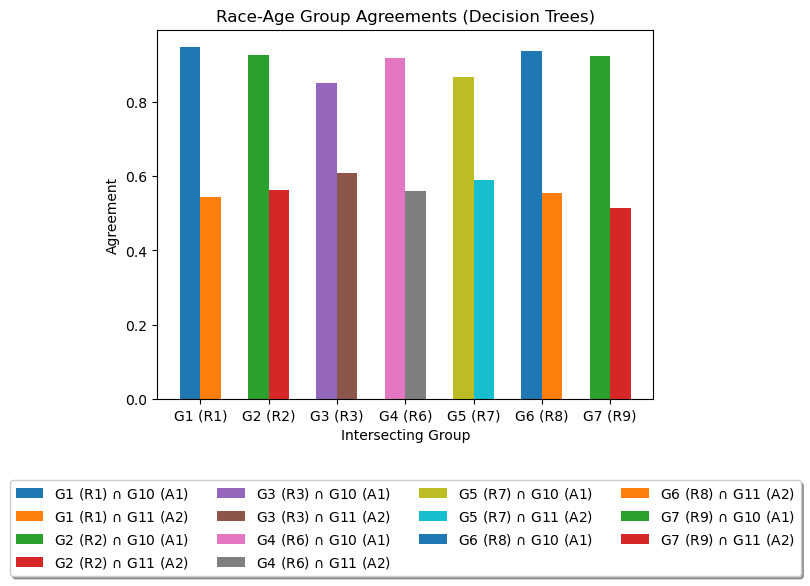

In [76]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, dt_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, dt_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Age Group Agreements (Decision Trees)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

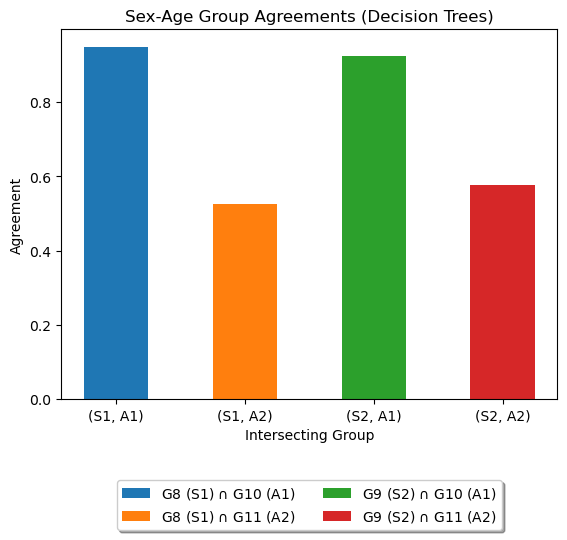

In [77]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 4
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.5

rect1 = ax.bar(0, dt_sex_age_agreements[0], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[0][0], group_names[sex_age_pairs[0][0]],
                                                            sex_age_pairs[0][1], group_names[sex_age_pairs[0][1]]))
rect2 = ax.bar(1, dt_sex_age_agreements[1], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[1][0], group_names[sex_age_pairs[1][0]],
                                                            sex_age_pairs[1][1], group_names[sex_age_pairs[1][1]]))
rect3 = ax.bar(2, dt_sex_age_agreements[2], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[2][0], group_names[sex_age_pairs[2][0]],
                                                            sex_age_pairs[2][1], group_names[sex_age_pairs[2][1]]))
rect4 = ax.bar(3, dt_sex_age_agreements[3], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[3][0], group_names[sex_age_pairs[3][0]],
                                                            sex_age_pairs[3][1], group_names[sex_age_pairs[3][1]]))


ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Sex-Age Group Agreements (Decision Trees)')
ax.set_xticks(index, ('(S1, A1)', '(S1, A2)', '(S2, A1)', '(S2, A2)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)

plt.show()

# Gradient-Boosted Trees

In [78]:
from sklearn.ensemble import GradientBoostingClassifier

In [80]:
LOAD_DATA = False
SAVE_DATA_PATH = 'employment_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'gbm_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'gbm_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'gbm_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        gbm_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    gbm_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        gbm_models[g] = GradientBoostingClassifier(**best_params[g])
        gbm_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = gbm_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(gbm_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

for g in range(num_groups):
    test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.18003643277886366 (+/-0.0019813597804882897; n=75207)
group 1 (R1): 0.1822091590845238 (+/-0.0025378548422241016; n=46271)
group 2 (R2): 0.18208245243128965 (+/-0.00887213709140339; n=3784)
group 3 (R3): 0.218568665377176 (+/-0.025704495681297648; n=517)
group 4 (R6): 0.1848577680525164 (+/-0.005135969584208841; n=11425)
group 5 (R7): 0.20357142857142857 (+/-0.03403045925982197; n=280)
group 6 (R8): 0.1798279054569219 (+/-0.005668276687765146; n=9181)
group 7 (R9): 0.14991577765300393 (+/-0.008459071368246161; n=3562)
group 8 (S1): 0.14929288012763312 (+/-0.0026208082940699165; n=36981)
group 9 (S2): 0.20977868466488778 (+/-0.002945036075991285; n=38226)
group 10 (A1): 0.18620243579226353 (+/-0.0021865647624193614; n=63388)
group 11 (A2): 0.14823589136136728 (+/-0.004622330387766275; n=11819)
group 0 (ALL): 0.18003643277886366 (+/-0.0019813597804882897; n=75207)
group 1 (R1): 0.1822091590845238 (+/-0.0025378548422241016; n=46271)
group 2 (R2): 0.18208245243128965 (+/-0

In [82]:
# Get "agreement" for each pair of intersecting groups
# Race-Sex Pairs
gb_race_sex_agreements = []
for g1, g2 in race_sex_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    gb_race_sex_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

# Race-Age Pairs
print()
gb_race_age_agreements = []
for g1, g2 in race_age_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    gb_race_age_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

# Sex-Age Pairs
print()
gb_sex_age_agreements = []
for g1, g2 in sex_age_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    gb_sex_age_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

(R1, S1) agreement:	0.938463174970415
(R1, S2) agreement:	0.9360963740077386
(R2, S1) agreement:	0.9000093076442353
(R2, S2) agreement:	0.9179863576528781
(R3, S1) agreement:	0.9236507240017552
(R3, S2) agreement:	0.9047695028388315
(R6, S1) agreement:	0.924076216309652
(R6, S2) agreement:	0.9032536864919489
(R7, S1) agreement:	0.8954352653343439
(R7, S2) agreement:	0.9066044384166367
(R8, S1) agreement:	0.9418538167989682
(R8, S2) agreement:	0.9252330235217466
(R9, S1) agreement:	0.9316287047748215
(R9, S2) agreement:	0.9152738441900355

(R1, A1) agreement:	0.944965229300464
(R1, A2) agreement:	0.5418112675681785
(R2, A1) agreement:	0.8856888321565811
(R2, A2) agreement:	0.5856635685507998
(R3, A1) agreement:	0.8911404523515098
(R3, A2) agreement:	0.5445237810310211
(R6, A1) agreement:	0.9089579427446913
(R6, A2) agreement:	0.5538846118047522
(R7, A1) agreement:	0.8764343744598242
(R7, A2) agreement:	0.5569694310370046
(R8, A1) agreement:	0.9324796893906152
(R8, A2) agreement:	0.53283

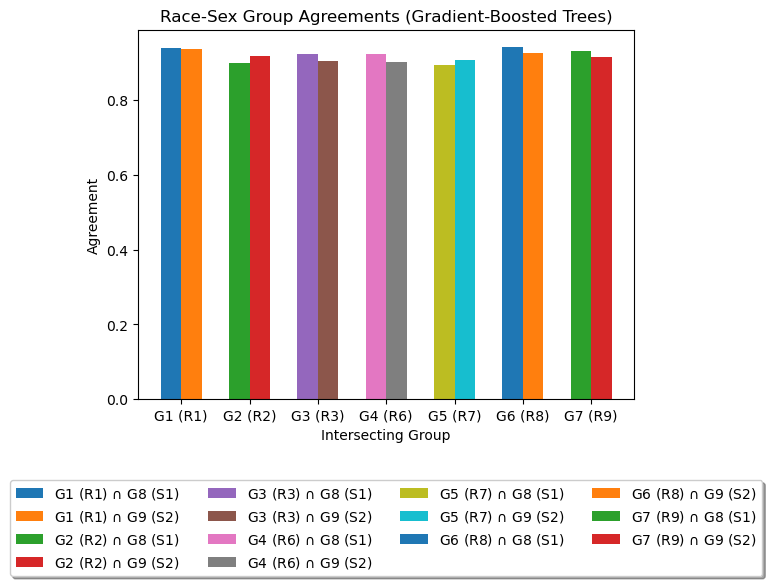

In [83]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, gb_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, gb_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Sex Group Agreements (Gradient-Boosted Trees)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

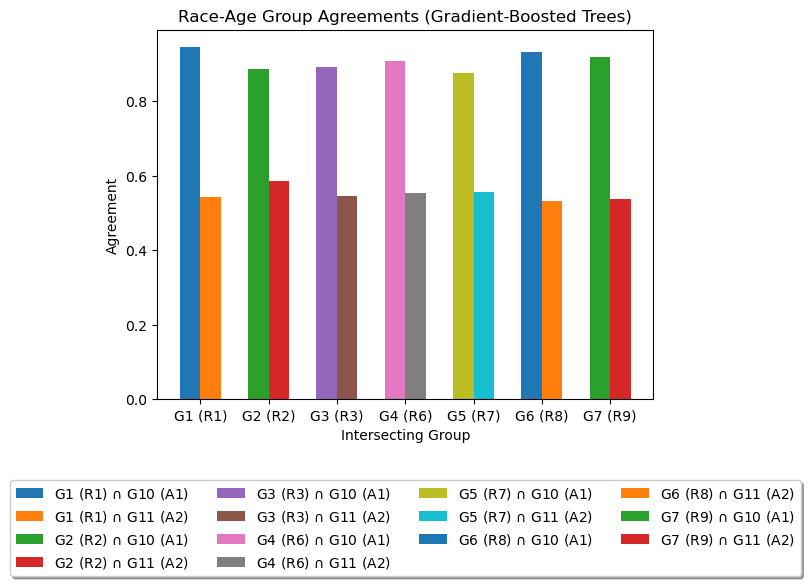

In [84]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, gb_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, gb_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Age Group Agreements (Gradient-Boosted Trees)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

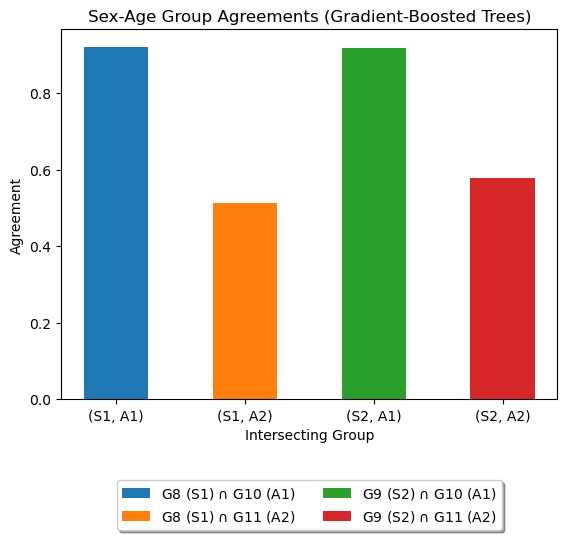

In [85]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 4
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.5

rect1 = ax.bar(0, gb_sex_age_agreements[0], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[0][0], group_names[sex_age_pairs[0][0]],
                                                            sex_age_pairs[0][1], group_names[sex_age_pairs[0][1]]))
rect2 = ax.bar(1, gb_sex_age_agreements[1], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[1][0], group_names[sex_age_pairs[1][0]],
                                                            sex_age_pairs[1][1], group_names[sex_age_pairs[1][1]]))
rect3 = ax.bar(2, gb_sex_age_agreements[2], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[2][0], group_names[sex_age_pairs[2][0]],
                                                            sex_age_pairs[2][1], group_names[sex_age_pairs[2][1]]))
rect4 = ax.bar(3, gb_sex_age_agreements[3], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[3][0], group_names[sex_age_pairs[3][0]],
                                                            sex_age_pairs[3][1], group_names[sex_age_pairs[3][1]]))


ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Sex-Age Group Agreements (Gradient-Boosted Trees)')
ax.set_xticks(index, ('(S1, A1)', '(S1, A2)', '(S2, A1)', '(S2, A2)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)

plt.show()

# XGBoost

In [86]:
from xgboost import XGBClassifier

In [87]:
LOAD_DATA = False
SAVE_DATA_PATH = 'employment_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'xgb_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'xgb_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'xgb_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        xgb_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    xgb_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        xgb_models[g] = XGBClassifier(**best_params[g])
        xgb_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = xgb_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(xgb_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

for g in range(num_groups):
    test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.17975720345180635 (+/-0.001980159753687931; n=75207)
group 1 (R1): 0.1811285686499103 (+/-0.002531989454548439; n=46271)
group 2 (R2): 0.17653276955602537 (+/-0.008765471095428416; n=3784)
group 3 (R3): 0.24758220502901354 (+/-0.026844725575543658; n=517)
group 4 (R6): 0.18669584245076587 (+/-0.005155617782988295; n=11425)
group 5 (R7): 0.21785714285714286 (+/-0.034887104470119584; n=280)
group 6 (R8): 0.1783030171005337 (+/-0.005649437342994943; n=9181)
group 7 (R9): 0.15384615384615385 (+/-0.008549407707349696; n=3562)
group 8 (S1): 0.14972553473405262 (+/-0.002623935633332468; n=36981)
group 9 (S2): 0.21048501020247998 (+/-0.002948671189579974; n=38226)
group 10 (A1): 0.18604467722597337 (+/-0.0021858501291164294; n=63388)
group 11 (A2): 0.14815128183433454 (+/-0.004621240548377646; n=11819)
group 0 (ALL): 0.17975720345180635 (+/-0.001980159753687931; n=75207)
group 1 (R1): 0.1811285686499103 (+/-0.002531989454548439; n=46271)
group 2 (R2): 0.17653276955602537 (+/-0

In [88]:
# Get "agreement" for each pair of intersecting groups
# Race-Sex Pairs
xgb_race_sex_agreements = []
for g1, g2 in race_sex_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    xgb_race_sex_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

# Race-Age Pairs
print()
xgb_race_age_agreements = []
for g1, g2 in race_age_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    xgb_race_age_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

# Sex-Age Pairs
print()
xgb_sex_age_agreements = []
for g1, g2 in sex_age_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    xgb_sex_age_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

(R1, S1) agreement:	0.943356336511229
(R1, S2) agreement:	0.9397263552594838
(R2, S1) agreement:	0.9303788211203744
(R2, S2) agreement:	0.9358437379499249
(R3, S1) agreement:	0.9281183932346723
(R3, S2) agreement:	0.905155105242863
(R6, S1) agreement:	0.9325195792944806
(R6, S2) agreement:	0.9071097105322643
(R7, S1) agreement:	0.9142632999587804
(R7, S2) agreement:	0.9071230071668861
(R8, S1) agreement:	0.9457098408392836
(R8, S2) agreement:	0.9346603374685867
(R9, S1) agreement:	0.9322403499674232
(R9, S2) agreement:	0.917866687941282

(R1, A1) agreement:	0.9506827821878283
(R1, A2) agreement:	0.5534857127660989
(R2, A1) agreement:	0.9186378927493452
(R2, A2) agreement:	0.5695214541199622
(R3, A1) agreement:	0.8919914369673035
(R3, A2) agreement:	0.5265467310223783
(R6, A1) agreement:	0.9151142845745742
(R6, A2) agreement:	0.5637640113287327
(R7, A1) agreement:	0.8857686119643118
(R7, A2) agreement:	0.5513316579573709
(R8, A1) agreement:	0.9427446913186273
(R8, A2) agreement:	0.55033

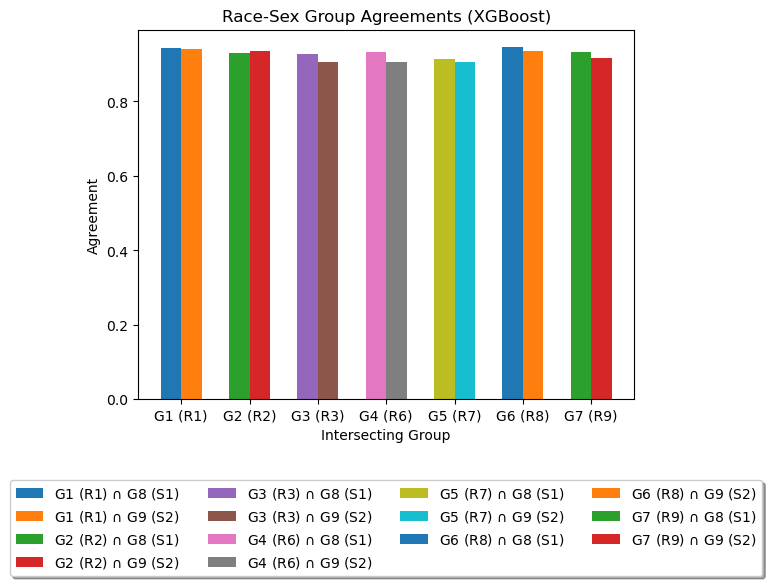

In [89]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, xgb_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, xgb_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Sex Group Agreements (XGBoost)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

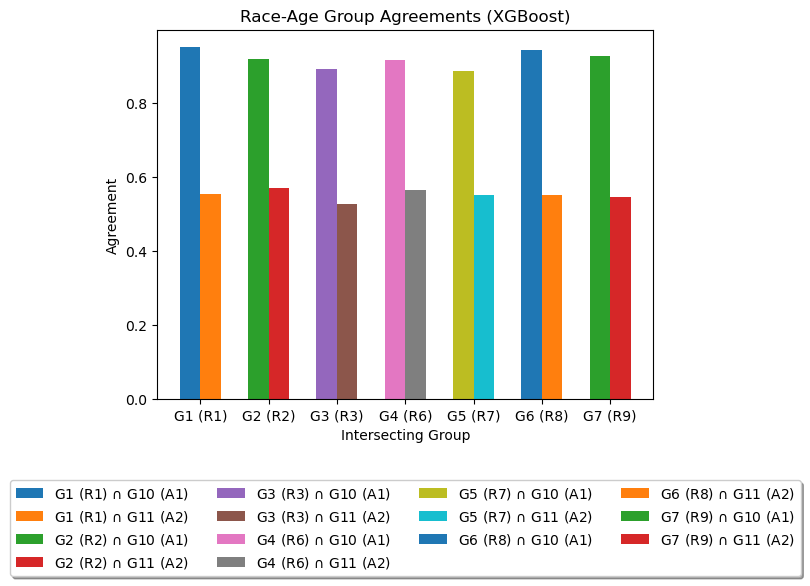

In [90]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, xgb_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, xgb_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Age Group Agreements (XGBoost)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

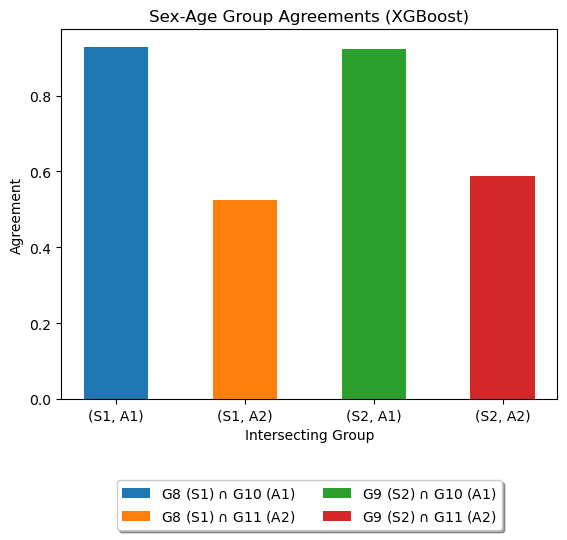

In [91]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 4
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.5

rect1 = ax.bar(0, xgb_sex_age_agreements[0], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[0][0], group_names[sex_age_pairs[0][0]],
                                                            sex_age_pairs[0][1], group_names[sex_age_pairs[0][1]]))
rect2 = ax.bar(1, xgb_sex_age_agreements[1], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[1][0], group_names[sex_age_pairs[1][0]],
                                                            sex_age_pairs[1][1], group_names[sex_age_pairs[1][1]]))
rect3 = ax.bar(2, xgb_sex_age_agreements[2], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[2][0], group_names[sex_age_pairs[2][0]],
                                                            sex_age_pairs[2][1], group_names[sex_age_pairs[2][1]]))
rect4 = ax.bar(3, xgb_sex_age_agreements[3], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[3][0], group_names[sex_age_pairs[3][0]],
                                                            sex_age_pairs[3][1], group_names[sex_age_pairs[3][1]]))


ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Sex-Age Group Agreements (XGBoost)')
ax.set_xticks(index, ('(S1, A1)', '(S1, A2)', '(S2, A1)', '(S2, A2)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)

plt.show()

# AdaBoost

In [92]:
from sklearn.ensemble import AdaBoostClassifier

In [94]:
LOAD_DATA = False
SAVE_DATA_PATH = 'employment_agreement_data/'
best_params_path = os.path.join(SAVE_DATA_PATH, 'ada_params.pkl')
model_path = os.path.join(SAVE_DATA_PATH, 'ada_models.pkl')
preds_path = os.path.join(SAVE_DATA_PATH, 'ada_yhats.pkl')

if LOAD_DATA:
    with open(model_path, 'rb') as f:
        ada_models = pickle.load(f)
    with open(preds_path, 'rb') as f:
        yhats = pickle.load(f)
else:
    with open(best_params_path, 'rb') as f:
        best_params = pickle.load(f)

    # Refit the models using the best params for each group
    ada_models = {}
    yhats = {}
    test_err = {}
    for g in range(num_groups):
        ada_models[g] = AdaBoostClassifier(**best_params[g])
        ada_models[g].fit(col_transf.transform(X_train[group_train[g]]), y_train[group_train[g]])
        yhats[g] = ada_models[g].predict(col_transf.transform(X_test))
        test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
        print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

    with open(model_path, 'wb') as handle:
        pickle.dump(ada_models, handle, protocol=pickle.HIGHEST_PROTOCOL)
    with open(preds_path, 'wb') as handle:
        pickle.dump(yhats, handle, protocol=pickle.HIGHEST_PROTOCOL)

for g in range(num_groups):
    test_err[g] = np.mean(y_test[group_test[g]] != yhats[g][group_test[g]])
    print('group {0} ({4}): {1} (+/-{2}; n={3})'.format(g,test_err[g], std_err(test_err[g], num_group_test[g]), num_group_test[g], group_names[g]))

group 0 (ALL): 0.1879080404749558 (+/-0.002014471615586927; n=75207)
group 1 (R1): 0.18800112381405198 (+/-0.0025687302011679126; n=46271)
group 2 (R2): 0.18234672304439747 (+/-0.0088771387155752; n=3784)
group 3 (R3): 0.24177949709864605 (+/-0.026630371390428526; n=517)
group 4 (R6): 0.194835886214442 (+/-0.005240389576736578; n=11425)
group 5 (R7): 0.225 (+/-0.03529214805428701; n=280)
group 6 (R8): 0.18832371201394182 (+/-0.005770506525692614; n=9181)
group 7 (R9): 0.1527231892195396 (+/-0.008523798855946686; n=3562)
group 8 (S1): 0.15480922635948188 (+/-0.0026601214576220055; n=36981)
group 9 (S2): 0.21456600219745722 (+/-0.0029694148275131176; n=38226)
group 10 (A1): 0.19522622578406007 (+/-0.0022264731389970067; n=63388)
group 11 (A2): 0.14823589136136728 (+/-0.004622330387766275; n=11819)
group 0 (ALL): 0.1879080404749558 (+/-0.002014471615586927; n=75207)
group 1 (R1): 0.18800112381405198 (+/-0.0025687302011679126; n=46271)
group 2 (R2): 0.18234672304439747 (+/-0.00887713871557

In [95]:
# Get "agreement" for each pair of intersecting groups
# Race-Sex Pairs
ada_race_sex_agreements = []
for g1, g2 in race_sex_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    ada_race_sex_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

# Race-Age Pairs
print()
ada_race_age_agreements = []
for g1, g2 in race_age_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    ada_race_age_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

# Sex-Age Pairs
print()
ada_sex_age_agreements = []
for g1, g2 in sex_age_pairs:
    agreement = np.sum(yhats[g1] == yhats[g2])/len(y_test)
    ada_sex_age_agreements.append(agreement)
    print("({}, {}) agreement:\t{}".format(group_names[g1], group_names[g2], agreement))

(R1, S1) agreement:	0.9624901937319664
(R1, S2) agreement:	0.9307511268897842
(R2, S1) agreement:	0.9181991038068265
(R2, S2) agreement:	0.9384764716050368
(R3, S1) agreement:	0.9410826119909051
(R3, S2) agreement:	0.9253792865025862
(R6, S1) agreement:	0.9357107716037071
(R6, S2) agreement:	0.9204329384232851
(R7, S1) agreement:	0.9398194317018362
(R7, S2) agreement:	0.9291422341005492
(R8, S1) agreement:	0.9417341470873721
(R8, S2) agreement:	0.9262435677530018
(R9, S1) agreement:	0.9407103062214953
(R9, S2) agreement:	0.9325062826598588

(R1, A1) agreement:	0.9288098182350047
(R1, A2) agreement:	0.4941561290837289
(R2, A1) agreement:	0.8945177975454413
(R2, A2) agreement:	0.5421968699722101
(R3, A1) agreement:	0.894770433603255
(R3, A2) agreement:	0.5001396146635286
(R6, A1) agreement:	0.9045301634156395
(R6, A2) agreement:	0.5179836983259537
(R7, A1) agreement:	0.8937731860066217
(R7, A2) agreement:	0.5002592843751247
(R8, A1) agreement:	0.9383966917973061
(R8, A2) agreement:	0.492

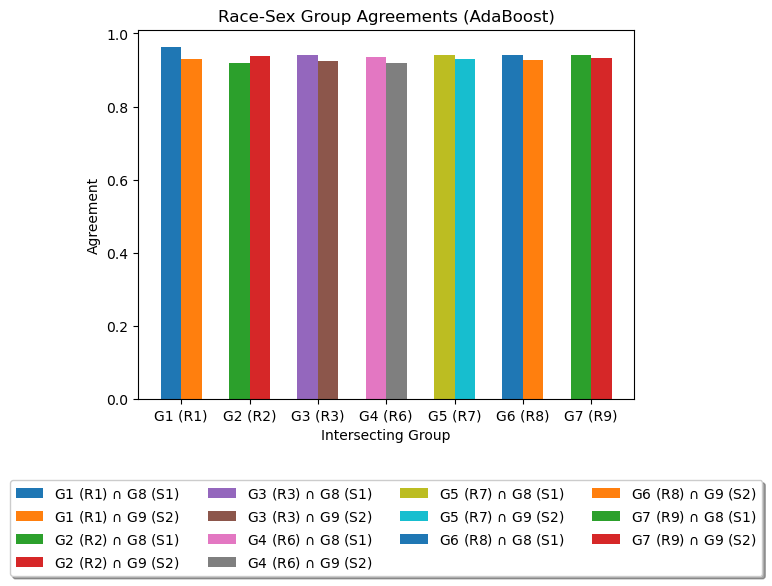

In [96]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, ada_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, ada_race_sex_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_sex_pairs[i][0], group_names[race_sex_pairs[i][0]],
                                                            race_sex_pairs[i][1], group_names[race_sex_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Sex Group Agreements (AdaBoost)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

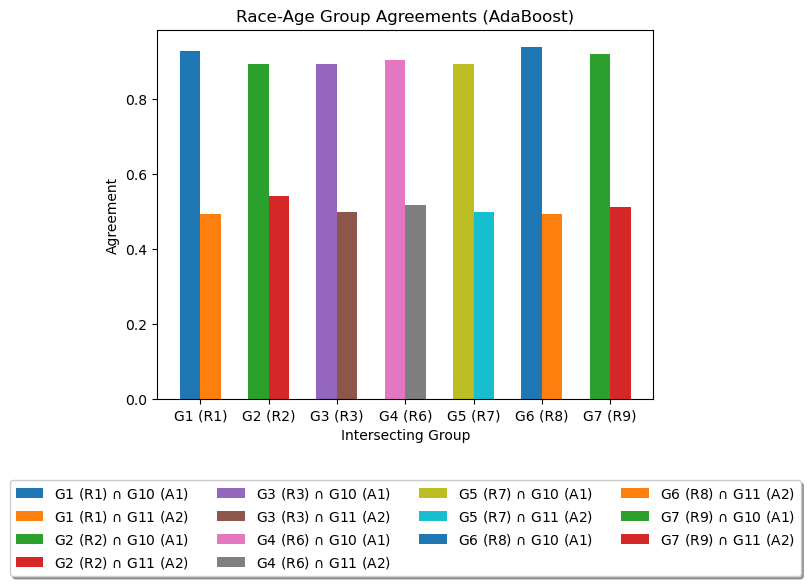

In [97]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 14
bar_groups = 7
index = np.arange(bar_groups)
bar_width = 0.3

for i in range(num_bars):
    if i % 2 == 0:
        ax.bar(int(i/2) - bar_width/2, ada_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))
    elif i % 2 == 1:
        ax.bar(int(i/2) + bar_width/2, ada_race_age_agreements[i], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(race_age_pairs[i][0], group_names[race_age_pairs[i][0]],
                                                            race_age_pairs[i][1], group_names[race_age_pairs[i][1]]))

ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Race-Age Group Agreements (AdaBoost)')
ax.set_xticks(index, ('G1 (R1)', 'G2 (R2)', 'G3 (R3)', 'G4 (R6)', 'G5 (R7)', 'G6 (R8)', 'G7 (R9)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=4)

plt.show()

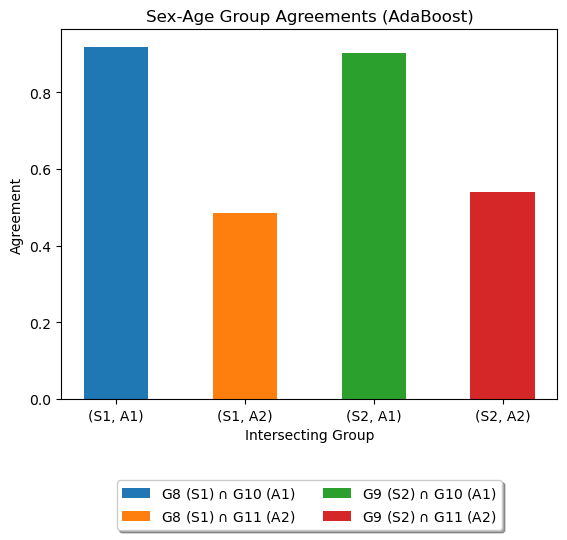

In [98]:
# Plot "agreement" for each pair of intersecting groups
fig, ax = plt.subplots()
num_bars = 4
bar_groups = 4
index = np.arange(bar_groups)
bar_width = 0.5

rect1 = ax.bar(0, ada_sex_age_agreements[0], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[0][0], group_names[sex_age_pairs[0][0]],
                                                            sex_age_pairs[0][1], group_names[sex_age_pairs[0][1]]))
rect2 = ax.bar(1, ada_sex_age_agreements[1], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[1][0], group_names[sex_age_pairs[1][0]],
                                                            sex_age_pairs[1][1], group_names[sex_age_pairs[1][1]]))
rect3 = ax.bar(2, ada_sex_age_agreements[2], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[2][0], group_names[sex_age_pairs[2][0]],
                                                            sex_age_pairs[2][1], group_names[sex_age_pairs[2][1]]))
rect4 = ax.bar(3, ada_sex_age_agreements[3], bar_width, 
                    label="G{} ({}) $\cap$ G{} ({})".format(sex_age_pairs[3][0], group_names[sex_age_pairs[3][0]],
                                                            sex_age_pairs[3][1], group_names[sex_age_pairs[3][1]]))


ax.set_xlabel('Intersecting Group')
ax.set_ylabel('Agreement')
ax.set_title('Sex-Age Group Agreements (AdaBoost)')
ax.set_xticks(index, ('(S1, A1)', '(S1, A2)', '(S2, A1)', '(S2, A2)'))
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2),
          fancybox=True, shadow=True, ncol=2)

plt.show()